In [1]:
%matplotlib inline

#import math tools
import numpy as np

#import miscellaneous tools
from itertools import permutations, repeat
import pprint as pp

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools
import pandas as pd
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# importing tools for running QAOA
import random
from scipy.optimize import minimize, fmin, Bounds
from sympy.combinatorics.graycode import GrayCode

In [2]:
from qiskit import IBMQ
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
# Problem variables

num_weeks = 1
num_days = 1 #5
num_periods = 4
num_timeslots = num_days*num_periods

# Each subject has only one teacher
# Each teacher teaches only one subject
num_subjects = 3
num_teachers = num_subjects #21


num_students = 2 #11
num_rooms = 3

# Number of features in a room
# Ex.: has computers, has >40 chairs...
num_features = 2

In [4]:
timetable = [[0 for i in range(num_periods)] for j in range(num_days)]

teachers_list = [teacher for teacher in range(num_teachers)]

students_list = [student for student in range(num_students)]

In [5]:
#     r0 r1 r2
# f0 [ 0  0  0 ]
# f1 [ 0  0  0 ]
#roomFeatures = np.matrix([[0 for feature in range(num_rooms)] for event in range(num_features)])
roomFeatures = np.matrix([[0, 1, 1],
                          [1, 0, 0]])


#     f0 f1
# s0 [ 0  0 ]
# s1 [ 0  0 ]
# s2 [ 0  0 ]
# s3 [ 0  0 ]
#subjectFeatures = np.matrix([[0 for feature in range(num_features)] for event in range(num_subjects)])
subjectFeatures = np.matrix([[1, 0],
                             [1, 0],
                             [0, 1]])


#     r0 r1 r2
# s0 [ 0  1  1 ]
# s1 [ 0  1  1 ]
# s2 [ 1  0  0 ]
# s3 [ 0  1  1 ]
suitableRoom = subjectFeatures*roomFeatures
print(suitableRoom)

[[0 1 1]
 [0 1 1]
 [1 0 0]]


In [6]:
# Allocate rooms
# Each subject will be allocated to the least busy room
allocations = []
num_allocations = [0 for room in range(num_rooms)]

for subject_index, subject in enumerate(suitableRoom.tolist()):
    possible_allocations = []
    for index, room in enumerate(subject):
        if room == 1:
            possible_allocations.append(index)
    print("Subject", subject)
    print("Possible Allocations", possible_allocations)
    
    min_allocations = np.inf
    allocated_room = np.inf
    for alloc_index in possible_allocations:
        if num_allocations[alloc_index] < min_allocations:
            allocated_room = alloc_index
            min_allocations = num_allocations[allocated_room]
    allocations.append((subject_index, allocated_room))
    num_allocations[allocated_room] += 1

print("Number of Allocations for each Room", num_allocations)
print("Allocations", allocations)

Subject [0, 1, 1]
Possible Allocations [1, 2]
Subject [0, 1, 1]
Possible Allocations [1, 2]
Subject [1, 0, 0]
Possible Allocations [0]
Number of Allocations for each Room [1, 1, 1]
Allocations [(0, 1), (1, 2), (2, 0)]


In [7]:
# Pair subjects with students
# lecture = (subject, room, student)
lectures = [(j,k,l) for j,k in allocations for l in students_list]

print(lectures)

[(0, 1, 0), (0, 1, 1), (1, 2, 0), (1, 2, 1), (2, 0, 0), (2, 0, 1)]


In [8]:
# Generate the lectureConflict Matrix
# The hard constraints of the problem are included in the matrix

#     l0 l1 l2 l3
# l0 [ 0  0  0  0 ]
# l1 [ 0  0  0  0 ]
# l2 [ 0  0  0  0 ]
# l3 [ 0  0  0  0 ]
lectureConflict = [[0 for feature in range(len(lectures))] for event in range(len(lectures))]

# If two lectures are allocated to the same room,
# share a student or have the same teacher they
# cannot be assigned to the same timeslot
for e, j in enumerate(lectures):
    subject,room,student = j
    for f,a in enumerate(lectures[e+1:]):
        subject2,room2,student2 = a
        if subject == subject2:
            lectureConflict[e][e+1+f] = 1
            lectureConflict[e+1+f][e] = 1
        if student == student2:
            lectureConflict[e][e+1+f] = 1
            lectureConflict[e+1+f][e] = 1
        if room == room2:
            lectureConflict[e][e+1+f] = 1
            lectureConflict[e+1+f][e] = 1

pp.pprint(lectureConflict)

[[0, 1, 1, 0, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 0, 1],
 [1, 0, 1, 0, 0, 1],
 [0, 1, 0, 1, 1, 0]]


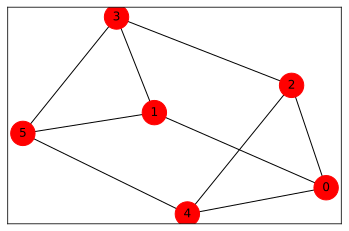

In [9]:
G = nx.Graph()
G.add_nodes_from([(num, {'color' : None}) for num in range(len(lectures))])

for e, row in enumerate(lectureConflict):
    for f, column in enumerate(row):
        if column == 1:
            G.add_edge(e,f)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [10]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

In [17]:
def color_graph_num(graph, num_color):
    color_index = 0
    not_allowed_color = []

    # Mark all the vertices as not visited
    visited = [False] * (graph.number_of_nodes())

    # Create a queue for BFS
    queue = []

    # Mark the source node as
    # visited and enqueue it
    queue.append(0)
    visited[0] = True

    while queue:
        # Dequeue a vertex from
        # queue and print it
        source = queue.pop(0)
        not_allowed_color = [graph.nodes[neighbour]['color'] for neighbour in graph[source] 
                                if (graph.nodes[neighbour]['color'] != None 
                                    and graph.nodes[neighbour]['color'] < num_color) ]

        while color_index in not_allowed_color:
            color_index = (color_index+1)%num_color
        G.nodes[source]['color'] = color_index
        not_allowed_color = []

        # Get all adjacent vertices of the
        # dequeued vertex s. If a adjacent
        # has not been visited, then mark it
        # visited and enqueue it
        for i in graph[source]:
            if visited[i] == False:
                queue.append(i)
                visited[i] = True

    return

In [18]:
def color_graph_coloring(graph, coloring):
    for i in G.nodes:
        G.nodes[i]['color'] = coloring[i]
    
    return

In [19]:
# Graph Information
print("Graph information")
degree = [deg for (node, deg) in G.degree()]
print("\nDegree of each node", degree)

num_colors = num_timeslots
print("\nNumber of colors", num_colors)

color_graph_num(G, num_colors)

for i in G.nodes:
    print("\nNode",i,"Color", G.nodes[i]['color'])
    neighbours = [G.nodes[neighbour]['color'] for neighbour in G[i]]
    print("Neighbours Colors", neighbours)

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nInitial coloring", coloring)

Graph information

Degree of each node [3, 3, 3, 3, 3, 3]

Number of colors 4

Node 0 Color 0
Neighbours Colors [1, 1, 2]

Node 1 Color 1
Neighbours Colors [0, 2, 3]

Node 2 Color 1
Neighbours Colors [0, 2, 2]

Node 3 Color 2
Neighbours Colors [1, 1, 3]

Node 4 Color 2
Neighbours Colors [0, 1, 3]

Node 5 Color 3
Neighbours Colors [1, 2, 2]

Initial coloring [0, 1, 1, 2, 2, 3]


In [20]:
class QAOAMinGraphColoring:

    def __init__(self, graph, num_colors):
        # Inital number of colors, usually graph's degree+2
        self.num_colors = num_colors

        # The graph is a dictionary
        self.graph = graph

        # Number of vertices in the graph
        self.num_nodes = self.graph.number_of_nodes()

        self.circuit = QuantumCircuit((self.num_nodes*self.num_colors)+1,
                (self.num_nodes*self.num_colors)+1)

    # Controlled Rz rotation for phase_separation and toffoli
    # The target qubit will always be the last one of the qubits
    # in the vector 'qubits'
    def cRz(self, qubits, gamma):
        num_qubits = len(qubits)
        qubits_t = qubits[1:]
        exp = np.power(2, num_qubits-1)
        a = GrayCode(num_qubits)
        gray_list = list(a.generate_gray())[1:]

    # Add the necessary gates following the Gray Code
        self.circuit.u1(gamma/exp, qubits[0])
        self.circuit.cx(qubits[0], qubits[1])
        counter = 1
        for i, node in enumerate(qubits_t):
            for j in range(np.power(2, i+1)-1):
                self.circuit.u1(np.power(-1, counter)*gamma/exp, node)
                counter += 1
                codes = zip(gray_list[counter-1][::-1], gray_list[counter][::-1])
                enumerator = 0
                for u,v in codes:
                    if u != v:
                        self.circuit.cx(qubits[enumerator], node)
                    enumerator += 1
            if i < len(qubits_t)-1:
                self.circuit.u1(np.power(-1, counter)*gamma/exp, node)
                counter += 1
                self.circuit.cx(node, qubits_t[i+1])
        self.circuit.u1(np.power(-1, counter)*np.pi/exp, qubits_t[-1])

    # N-qubit controlled Toffoli gate
    def toffoli(self, controls, target):
        all_qubits = controls+[target]
        self.circuit.h(target)
        self.cRz(all_qubits, np.pi)
        self.circuit.h(target)

    def find_sequence(self, pos_b, start):
        sequence = []
        end = pos_b[start]
        while end != start:
            sequence.append(end)
            end = pos_b[end]

        sequence.append(start)
        return sequence

    def qubits2color(self):
        dit_ord = []
        col_ord = []
        for i in range(self.num_nodes):
            for j in range(self.num_colors):
                pos_a = i*self.num_colors+j
                pos_b = j*self.num_nodes+i
                dit_ord.append(pos_a)
                col_ord.append(pos_b)

        not_visited = set(dit_ord)

        while not_visited:
            ind = next(iter(not_visited))
            sequence = self.find_sequence(col_ord, ind)

            for pos in sequence:
                not_visited.remove(pos)

            if len(sequence) != 1:
                start = sequence.pop()
                while sequence:
                    qubit_b = sequence.pop()
                    self.circuit.swap(qubit_b, start)
                    start = qubit_b
    
    def color2qubits(self):
        dit_ord = []
        col_ord = []
        for j in range(self.num_colors):
            for i in range(self.num_nodes):
                pos_a = i*self.num_colors+j
                pos_b = j*self.num_nodes+i
                dit_ord.append(pos_a)
                col_ord.append(pos_b)

        not_visited = set(col_ord)

        while not_visited:
            ind = next(iter(not_visited))
            sequence = self.find_sequence(dit_ord, ind)

            for pos in sequence:
                not_visited.remove(pos)

            if len(sequence) != 1:
                start = sequence.pop()
                while sequence:
                    qubit_b = sequence.pop()
                    self.circuit.swap(qubit_b, start)
                    start = qubit_b


    # Prepare the initial state of QAOA
    # Add a X gate to color the vertices following the one-hot notation
    def initial_state(self, coloring):
        for i, color in enumerate(coloring):
            self.circuit.x((i*self.num_colors)+color)
        return

    def w3_state_generation(self):
        for i in range(self.num_nodes):
            self.circuit.ry(np.pi/4, i*self.num_colors+1)
            self.circuit.ry(np.arccos(-1/3), i*self.num_colors+2)
            self.circuit.rz(-np.pi/2, i*self.num_colors+2)
            self.circuit.cx(i*self.num_colors+2, i*self.num_colors+1)
            self.circuit.ry(-np.pi/4, i*self.num_colors+1)
            self.circuit.rz(np.pi/2, i*self.num_colors+1)
            self.circuit.cx(i*self.num_colors+2, i*self.num_colors+1)
            self.circuit.rz(np.pi/2, i*self.num_colors+1)
            self.circuit.cx(i*self.num_colors+1, i*self.num_colors)
            self.circuit.cx(i*self.num_colors+2, i*self.num_colors+1)
            self.circuit.rx(np.pi, i*self.num_colors+2)
        return

    def w2_state_generation(self):
        for i in range(self.num_nodes):
            self.circuit.h(i*self.num_colors)
            self.circuit.x(i*self.num_colors+1)
            self.circuit.cx(i*self.num_colors, i*self.num_colors+1)
        return

    # First rearrange the order of the qubits so every color is adjacent to each other
    # Uses a controlled-Rz operation with a negative control to count the number of used colors
    # Order the qubits again so the qudits are in the right place
    def phase_separator(self, gamma):
        self.qubits2color()
        #self.circuit.barrier()
        for node in range(self.num_colors*self.num_nodes):
            self.circuit.x(node)
        for k in range(self.num_colors):
            qubits = [k*self.num_nodes+node for node in range(self.num_nodes)]
            self.cRz(qubits, gamma)
        for node in range(self.num_colors*self.num_nodes):
            self.circuit.x(node)
        #self.circuit.barrier()
        self.color2qubits()
        #self.circuit.barrier()

    def partial_mixer(self, neighbour, ancilla, target, beta):
        if neighbour == []:
            self.circuit.x(ancilla)
        else:
            for node in neighbour:
                self.circuit.x(node)
            self.toffoli(neighbour, ancilla)
            for node in neighbour:
                self.circuit.x(node)
        #self.circuit.barrier()

        # Controlled Rxx
        self.circuit.h(target[0])
        self.circuit.h(target[1])
        self.circuit.cx(target[0],target[1])
        self.cRz([ancilla]+[target[1]], beta)
        self.circuit.cx(target[0],target[1])
        self.circuit.h(target[0])
        self.circuit.h(target[1])

        # Controlled Ryy
        self.circuit.rx(-np.pi/2,target[0])
        self.circuit.rx(-np.pi/2,target[1])
        self.circuit.cx(target[0],target[1])
        self.cRz([ancilla]+[target[1]], beta)
        self.circuit.cx(target[0],target[1])
        self.circuit.rx(np.pi/2,target[0])
        self.circuit.rx(np.pi/2,target[1])

        #self.circuit.barrier()
        if neighbour == []:
            self.circuit.x(ancilla)
        else:
            for node in neighbour:
                self.circuit.x(node)
            self.toffoli(neighbour, ancilla)
            for node in neighbour:
                self.circuit.x(node)
        #self.circuit.barrier()

    def neighbourhood(self, node, color):
        neighbour = self.graph[node]
        neighbour_qubit = [color+(self.num_colors*u) for u in neighbour]

        return neighbour_qubit

    def mixer(self, beta):
        for u in range(self.num_nodes):
            for i in range(self.num_colors):
                neighbours_i = self.neighbourhood(u, i)
                for j in range(self.num_colors):
                    if i < j:
                        neighbours_j = self.neighbourhood(u, j)
                        neighbours = neighbours_i+neighbours_j
                        self.partial_mixer(neighbours,
                                self.num_nodes*self.num_colors,
                                [i+(self.num_colors*u), j+(self.num_colors*u)],
                                beta)

    def measurement(self):
        qubits = [num for num in range(self.num_nodes*self.num_colors+1)]
        self.circuit.measure(qubits, qubits)
        return

In [21]:
# Compute the value of the cost function
# Minimize the number of USED colors
def cost_function_C(x,G,num_colors):
            
    C = 0
    for color in range(num_colors):
        color_used = 0
        for node in G.nodes():
            if x[node*num_colors + color] == 1:
                color_used = 1
                break
        C += color_used
        
    return C

In [22]:
p = 1
gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
beta0 =  random.uniform(0, np.pi)
beta  = [random.uniform(0, np.pi) for _ in range(p)]

print("Using following parameters:\n ")
print("p: ", p)
print("Beta0: ", beta0)
print("Gamma: ", gamma)
print("Beta: ", beta)
print("\n")

QAOA_circ = QAOAMinGraphColoring(G, num_colors)

# Initial state preparation
QAOA_circ.initial_state(coloring)
#QAOA_circ.w2_state_generation()
#QAOA_circ.w3_state_generation()

# Alternate application of operators
# Mixer 0
QAOA_circ.mixer(beta0)
for step in range(p):
    QAOA_circ.phase_separator(gamma[step])
    QAOA_circ.mixer(beta[step])

# Measurement
QAOA_circ.measurement()

# Execute the circuit on the selected backend
#backend = provider.get_backend('ibmq_16_melbourne')
backend = Aer.get_backend('qasm_simulator')
backend_options = {"method" : "statevector_gpu"}
shots = 1000

optimized = transpile(QAOA_circ.circuit, backend=backend, seed_transpiler=11, optimization_level=2)
#optimized = transpile(QAOA_circ.circuit, backend=backend, seed_transpiler=11, optimization_level=3)

job = execute(optimized, backend, shots=shots, backend_options=backend_options)

# Grab results from the job
result = job.result()
print("Time taken: {} sec".format(result.time_taken))

#show_figure(plot_histogram(result.get_counts(),figsize = (8,6),bar_labels = False))

Using following parameters:
 
p:  1
Beta0:  1.0332060913936196
Gamma:  [6.23253965122892]
Beta:  [2.1911922603248315]


Time taken: 466.17875623703003 sec



 --- EXTRA RESULTS ---


Max Coloring [3, 3, 1, 1, 1, 3]

Max Coloring Qudits values
0001
0001
0100
0100
0100
0001

The approximate solution of max_counts = 0100000100010001010001000 with C(x*) = 2
The number of times this solution showed was: 7

 --- SIMULATION RESULTS ---

1000
0100
1000
1000
1000
1000

Final Coloring [0, 1, 0, 0, 0, 0]

Final Coloring Qudits values
1000
0100
1000
1000
1000
1000

The approximate solution is x* = 0000100010001000100100001 with C(x*) = 2
The number of times this solution showed was: 2 

The sampled mean value is Mp_sampled = 3.22
The cost function is distributed as: 



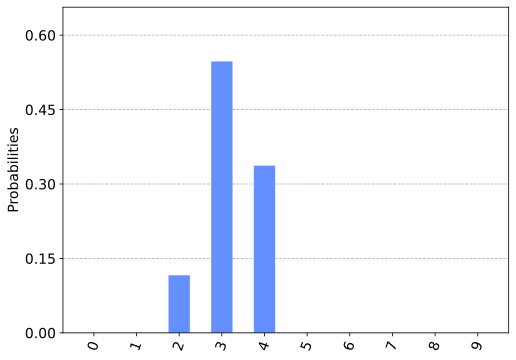

In [23]:
# Evaluate the data from the simulator
counts = result.get_counts()

avr_C       = 0
min_C       = [0, G.number_of_edges()]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G,num_colors)
        
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
        
    # save best bit string
    if( min_C[1] > tmp_eng):
        min_C[0] = sample
        min_C[1] = tmp_eng
                    
M1_sampled   = avr_C/shots   

print('\n --- EXTRA RESULTS ---\n')

max_counts = max(counts, key=lambda key: counts[key])
maximum_coloring = []
list_qubits = max_counts[::-1]

for i in range(len(G)):
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            maximum_coloring.append(pos)

print("\nMax Coloring", maximum_coloring)
print("\nMax Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

max_num = [int(num) for num in list(max_counts)]
max_fun   = cost_function_C(max_num,G,num_colors)
print('\nThe approximate solution of max_counts = %s with C(x*) = %d' % (max_counts,max_fun))
print('The number of times this solution showed was: %d' %(counts[max_counts]))


print('\n --- SIMULATION RESULTS ---\n')
#print("Initial Coloring", coloring)

final_coloring = []
list_qubits = min_C[0][::-1]
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            final_coloring.append(pos)

print("\nFinal Coloring",final_coloring)
print("\nFinal Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

print('\nThe approximate solution is x* = %s with C(x*) = %d' % (min_C[0],min_C[1]))
print('The number of times this solution showed was: %d \n' %(counts[min_C[0]]))

print('The sampled mean value is Mp_sampled = %.02f' % (M1_sampled))

print('The cost function is distributed as: \n') 
show_figure(plot_histogram(hist,figsize = (8,6),bar_labels = False))

In [26]:
# Graph Information
print("New Graph information")
degree = [deg for (node, deg) in G.degree()]
print("\nDegree of each node", degree)

num_colors = num_timeslots
print("\nNumber of colors", num_colors)

color_graph_coloring(G, maximum_coloring)

for i in G.nodes:
    print("\nNode",i,"Color", G.nodes[i]['color'])
    neighbours = [G.nodes[neighbour]['color'] for neighbour in G[i]]
    print("Neighbours Colors", neighbours)

coloring = [G.nodes[node]['color'] for node in G.nodes]
print("\nFinal coloring", final_coloring)

New Graph information

Degree of each node [3, 3, 3, 3, 3, 3]

Number of colors 4

Node 0 Color 3
Neighbours Colors [3, 1, 1]

Node 1 Color 3
Neighbours Colors [3, 1, 3]

Node 2 Color 1
Neighbours Colors [3, 1, 1]

Node 3 Color 1
Neighbours Colors [3, 1, 3]

Node 4 Color 1
Neighbours Colors [3, 1, 3]

Node 5 Color 3
Neighbours Colors [3, 1, 1]

Final coloring [0, 1, 0, 0, 0, 0]


In [ ]:
#backend = provider.get_backend('ibmq_16_melbourne')
qc = QAOA_circ.circuit

soma  = 0
soma0 = 0
soma1 = 0
soma2 = 0
soma3 = 0

print ('Original Circuit')
print('gates = ', qc.count_ops())
for i in qc.count_ops():
    soma += qc.count_ops()[i]
print('total gates = ', soma)
print('depth = ', qc.depth())

print('\nOptmization 0')
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
for i in optimized_0.count_ops():
    soma0 += optimized_0.count_ops()[i]
print('total gates = ', soma0)
print('depth = ', optimized_0.depth())

print('\nOptmization 1')
optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
print('gates = ', optimized_1.count_ops())
for i in optimized_1.count_ops():
    soma1 += optimized_1.count_ops()[i]
print('total gates = ', soma1)
print('depth = ', optimized_1.depth())

print('\nOptmization 2')
optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
print('gates = ', optimized_2.count_ops())
for i in optimized_2.count_ops():
    soma2 += optimized_2.count_ops()[i]
print('total gates = ', soma2)
print('depth = ', optimized_2.depth())

print('\nOptmization 3')
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
for i in optimized_3.count_ops():
    soma3 += optimized_3.count_ops()[i]
print('total gates = ', soma3)
print('depth = ', optimized_3.depth())

In [ ]:
# QAOA parameters
beta0 = random.uniform(0, np.pi)
gamma = random.uniform(0, 2*np.pi)

# Graph
# Graph
degree = [deg for (node, deg) in G.degree()]
num_colors = max(degree)+2
#num_colors = 3
coloring = color_graph(G, num_colors)
#coloring = [0,1,2,3]

QAOA_circ = QAOAMinGraphColoring(G, num_colors)

#QAOA_circ.initial_state(coloring)
# Mixer 0
QAOA_circ.mixer(beta0)
#QAOA_circ.phase_separator(gamma)
#QAOA_circ.measurement()

show_figure(QAOA_circ.circuit.draw())

In [ ]:
def QAOA(par, p, G):
    # QAOA parameters
    beta0, par= par[0], par[1:]
    middle = int(len(par)/2)
    gamma = par[:middle]
    beta = par[middle:]

    # Graph
    degree = [deg for (node, deg) in G.degree()]
    num_colors = max(degree)+2
    #num_colors = 3
    coloring = color_graph(G, num_colors)
    #coloring = [0,1,2,3]


    QAOA_circ = QAOAMinGraphColoring(G, num_colors)

    # Initial state preparation
    QAOA_circ.initial_state(coloring)
    #QAOA_circ.w2_state_generation()
    #QAOA_circ.w3_state_generation()

    # Alternate application of operators
    # Mixer 0
    QAOA_circ.mixer(beta0)
    for step in range(p):
        QAOA_circ.phase_separator(gamma[step])
        QAOA_circ.mixer(beta[step])

    # Measurement
    QAOA_circ.measurement()

    # Execute the circuit on the selected backend
    #backend = provider.get_backend('ibmq_16_melbourne')
    backend = Aer.get_backend('qasm_simulator')
    backend_options = {"method" : "statevector_gpu"}
    shots = 1000
    optimized_3 = transpile(QAOA_circ.circuit, backend=backend, seed_transpiler=11, optimization_level=3)
    
    job = execute(optimized_3, backend, shots=shots, backend_options=backend_options)

    # Grab results from the job
    result = job.result()

    # Evaluate the data from the simulator
    counts = result.get_counts()

    avr_C       = 0
    for sample in list(counts.keys()):
        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G,num_colors)
        
        # compute the expectation value and energy distribution
        avr_C     = avr_C    + counts[sample]*tmp_eng

    # Calculating f(x) by taking the average of the probability distribution           
    Mp_sampled   = avr_C/shots

    return Mp_sampled

In [ ]:
def save_csv(data, nome_csv):
    data_points = pd.DataFrame(data, columns=['Expected Value', 'p', 'Graph Number'])
    data_points.to_csv(nome_csv, mode='a', header=False)
    
    return

In [ ]:
p = 1
graph_num = 0
for iteration in range(1):
    Mp1_sampled = []
    gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
    beta0 =  [random.uniform(0, np.pi)]
    beta  = [random.uniform(0, np.pi) for _ in range(p)]
    QAOA_par = beta0+gamma+beta
    QAOA_args = p, G
    print("Minimizing function")
    res = minimize(QAOA, QAOA_par, args=QAOA_args, method='Nelder-Mead',
            options={'maxiter': 1, 'xatol': 0.1, 'fatol': 0.01, 'disp': True, 'adaptive':True})
    Mp1_sampled.append([res['fun'], p, graph_num])
    #save_csv(Mp1_sampled, archive_name)
    print(Mp1_sampled)

In [ ]:
graph_num = 0
p = 1
for G in G_list:
    archive_name = "results/p"+str(p)+"_g"+str(graph_num)+".csv"
    for iteration in range(10):
        Mp1_sampled = []
        gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
        beta  = [random.uniform(0, np.pi) for _ in range(p)]
        QAOA_par = gamma+beta
        QAOA_args = p, G
        print("Minimizing function")
        print(graph_num, iteration)
        res = minimize(QAOA, QAOA_par, args=QAOA_args, method='Nelder-Mead',
                options={'maxiter': 300, 'xatol': 0.1, 'fatol': 0.01, 'disp': True, 'adaptive':True})
        print(res)
        Mp1_sampled.append([res['fun'], p, graph_num])
        #save_csv(Mp1_sampled, archive_name)
        print(graph_num, iteration)
    graph_num += 1

In [ ]:
data = []
for i in range(10):
    data = []
    gname = str(i)

    data1 = pd.read_csv('../results/p1_g'+gname+'.csv', header=None)
    data2 = pd.read_csv('../results/p2_g'+gname+'.csv', header=None)
    data4 = pd.read_csv('../results/p4_g'+gname+'.csv', header=None)
    data8 = pd.read_csv('../results/p8_g'+gname+'.csv', header=None)

    data_col = data1.iloc[:,1]
    data.append(data_col.tolist())
    data_col = data2.iloc[:,1]
    data.append(data_col.tolist())
    data_col = data4.iloc[:,1]
    data.append(data_col.tolist())
    data_col = data8.iloc[:,1]
    data.append(data_col.tolist())

    fig = plt.figure()
    fig.suptitle('', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)

    ax.set_title('Graph '+gname)
    ax.set_xlabel('QAOA depth')
    ax.set_xticklabels(['1','2','4','8'])
    ax.set_ylabel('Expected Value')

    ax.boxplot(data,0,'')

    #plt.savefig("../results/pdf/g"+gname+".pdf")

In [ ]:
mean_values1 = []
mean_values2 = []
mean_values4 = []
mean_values8 = []

for num in range(10):
    data1 = pd.read_csv('../results/p1_g'+str(num)+'.csv', header=None)
    data2 = pd.read_csv('../results/p2_g'+str(num)+'.csv', header=None)
    data4 = pd.read_csv('../results/p4_g'+str(num)+'.csv', header=None)
    data8 = pd.read_csv('../results/p8_g'+str(num)+'.csv', header=None)

    mean_values1.append(np.mean(data1.iloc[:,1]))
    mean_values2.append(np.mean(data2.iloc[:,1]))
    mean_values4.append(np.mean(data4.iloc[:,1]))
    mean_values8.append(np.mean(data8.iloc[:,1]))

pos_list = [0,1,4,5,8]
for pos in pos_list:
    mean_values1[pos] -= 1
    mean_values2[pos] -= 1
    mean_values4[pos] -= 1
    mean_values8[pos] -= 1

diff = []

for e, i in enumerate(mean_values1):
    diff.append(i-mean_values2[e])

app_values1 = []
app_values2 = []
app_values4 = []
app_values8 = []

for e, G in enumerate(G_list):
    alfa1 = (G.number_of_edges()-mean_values1[e])/G.number_of_edges()
    app_values1.append(alfa1)
    alfa2 = (G.number_of_edges()-mean_values2[e])/G.number_of_edges()
    app_values2.append(alfa2)
    alfa4 = (G.number_of_edges()-mean_values4[e])/G.number_of_edges()
    app_values4.append(alfa4)
    alfa8 = (G.number_of_edges()-mean_values8[e])/G.number_of_edges()
    app_values8.append(alfa8)


print(mean_values1)
print(mean_values2)
print(diff)
print(max(diff))

In [ ]:
data_mean = [np.mean(app_values1), np.mean(app_values2), np.mean(app_values4), np.mean(app_values8)]
k = 3
alfa_classic = 1-(1 / (k+(2+(k))*((np.log(k))/k**2)))
data2_mean = [alfa_classic, alfa_classic, alfa_classic, alfa_classic]
x_mean = [1,2,4,8]

fig = plt.figure()
fig.suptitle('', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax.set_title('Comparison between QAOA and Classic Approximation')
ax.set_xlabel('QAOA depth')
ax.set_ylabel('Solution gap')

ax.plot(x_mean, data_mean, color='blue', marker='o', linestyle='--', linewidth=2, markersize=12, label='QAOA')
ax.plot(x_mean, data2_mean, color='blue', linestyle='-', linewidth=2, markersize=12, label='Classic')
ax.legend()

plt.xlim(0.5, 8.5)
plt.ylim(0.7, 0.725)

plt.savefig("solution_gap.pdf")